<h1>Stock price prediction using AutoRegressive Time Series</h1>
-<u>Anirudh Soma</u>
<hr>

Importing Necessary Libraries

In [217]:
import matplotlib.pyplot as plt
import pandas as pd
import plotly.express as px
import seaborn as sns
import yfinance as yf
from sklearn.metrics import mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg

Using the yahoo finance API to collect hourly stock data of TSLA

In [218]:
stock=yf.download(tickers=["TSLA"],start="2023-06-01",interval="1H")
stock=stock[::-1]

[*********************100%***********************]  1 of 1 completed


In [219]:
df=stock.copy()
df.drop(columns=["Adj Close"])

,Open,High,Low,Close,Volume
Datetime,,,,,
2023-09-05 09:30:00,245.000000,253.380005,244.860001,253.214996,34339783
2023-09-01 15:30:00,244.089996,245.479996,243.899994,244.990005,9946706
2023-09-01 14:30:00,242.919998,244.300003,242.009995,244.086502,15204391
2023-09-01 13:30:00,246.620697,247.070007,242.509995,242.910004,16014620
2023-09-01 12:30:00,246.763702,247.990005,246.360001,246.623795,11353569
...,...,...,...,...,...
2023-06-01 13:30:00,206.945007,208.690002,206.449493,208.261307,16486707
2023-06-01 12:30:00,206.399994,207.190002,205.000000,206.940399,15210230
2023-06-01 11:30:00,204.029999,206.889999,203.350006,206.414993,18729009


In [220]:
ts=pd.Series(df["Close"])
ts.index = pd.to_datetime(ts.index)
ts = ts.asfreq('H')
ts = ts.sort_index()

In [228]:
#Using 90% split for training and testing data
split=int(len(ts)*0.9)
y_train=ts.iloc[:split]
y_test=ts.iloc[split:]

In [227]:
#Forward filling missing values
ts=ts.fillna(method="ffill")

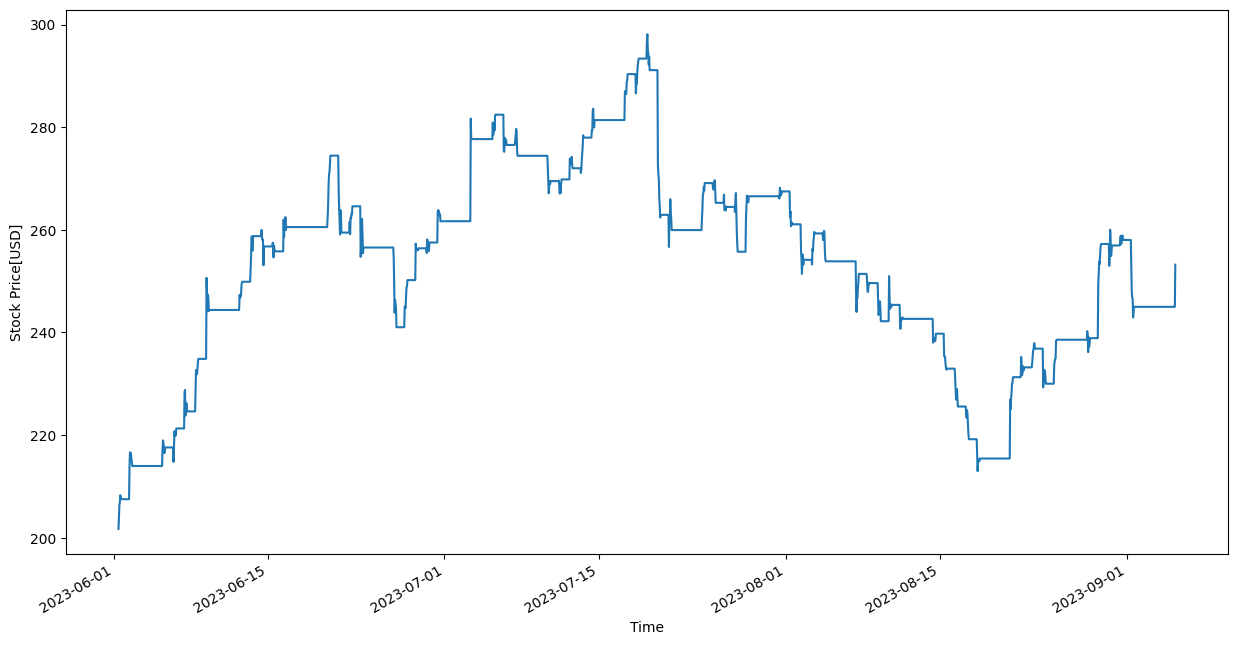

In [223]:
fig,ax=plt.subplots(figsize=(15,8))
ts.plot(ax=ax,xlabel="Time",ylabel="Stock Price[USD]");

PACF and ACF graphs

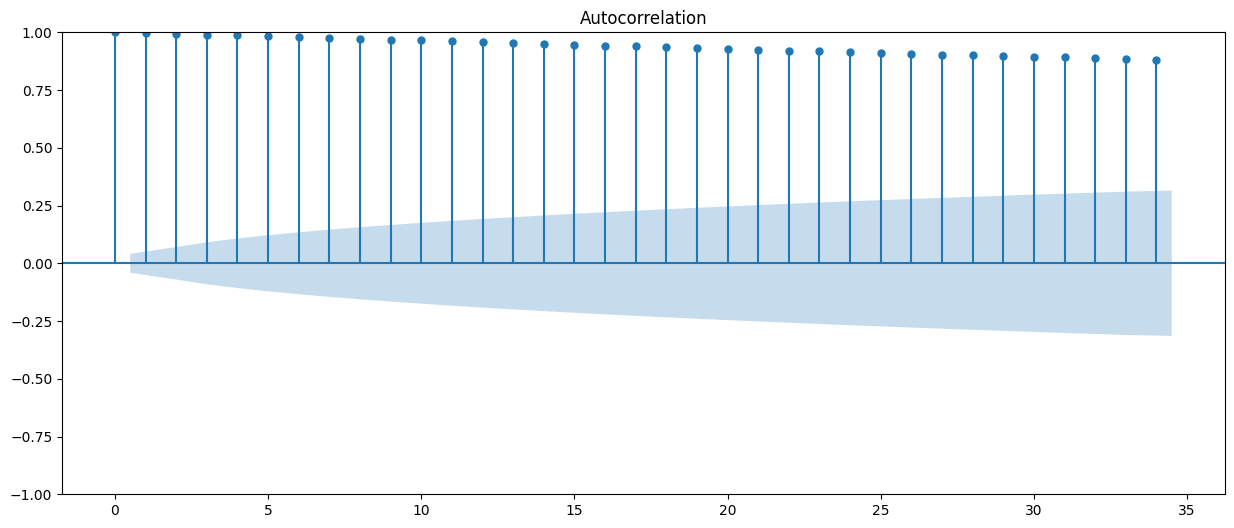

In [224]:
fig,ax=plt.subplots(figsize=(15,6))
plot_acf(ts,ax=ax);

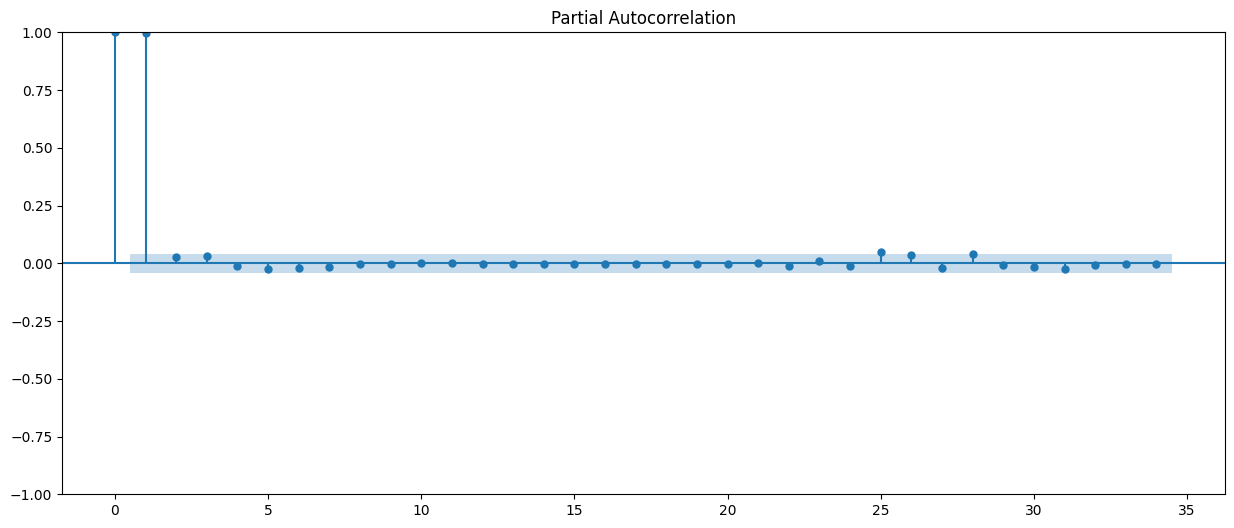

In [225]:
fig, ax =plt.subplots(figsize=(15,6))
plot_pacf(ts,ax=ax);

In [229]:
#Finding the optimal lag for the AR model
dict={}
upper_limit=26
for i in range(1,upper_limit):
    model=AutoReg(y_train,lags=i).fit()
    preds=model.predict().dropna()
    mae=mean_absolute_error(y_train[i:],preds)
    dict.update({i:mae})

In [230]:
print(dict)

{1: 0.4046692289370632, 2: 0.4021111416196969, 3: 0.40024063117093706, 4: 0.3999857930923649, 5: 0.4007510579067319, 6: 0.40211677445675714, 7: 0.403141303783747, 8: 0.40347930089731626, 9: 0.4038020765593829, 10: 0.4040002912478239, 11: 0.4041871473288898, 12: 0.4043884034865006, 13: 0.40460388130442154, 14: 0.4048216856652143, 15: 0.40503564094036715, 16: 0.4052546331422703, 17: 0.4054752699931524, 18: 0.4057013253797254, 19: 0.4060411732361279, 20: 0.4064158408250872, 21: 0.40690512228024855, 22: 0.4078248173134222, 23: 0.4090796953441562, 24: 0.41096564640633076, 25: 0.40448872282416143}


In [231]:
best_lag=min(dict,key=lambda k:dict[k])
print(f"The model performs with the least mean absolute error with lag parameter = {best_lag}")

The model performs with the least mean absolute error with lag parameter = 4


Creating a Baseline model

In [232]:
mean=y_train.mean()
baseline_pred=[mean]*len(y_train)
base_mae=mean_absolute_error(y_train,baseline_pred)
base_mae

16.14103562620531

Fitting the model to the training set

In [233]:
model=AutoReg(y_train,lags=4).fit()
y_pred=model.predict().dropna()
mae=mean_absolute_error(y_train[4:],y_pred)

In [234]:
time_diff = y_train.index.to_series().diff()

# Check for irregular time intervals
irregular_intervals = time_diff.value_counts().index.tolist()

if len(irregular_intervals) > 1:
    print("The time series is irregular.")
else:
    print("The time series is regular.")

The time series is regular.


In [235]:
print(f"The mean absolute error = {mae} (regarding the model's performance with the traning data) ")

The mean absolute error = 0.3999857930923649 (regarding the model's performance with the traning data) 


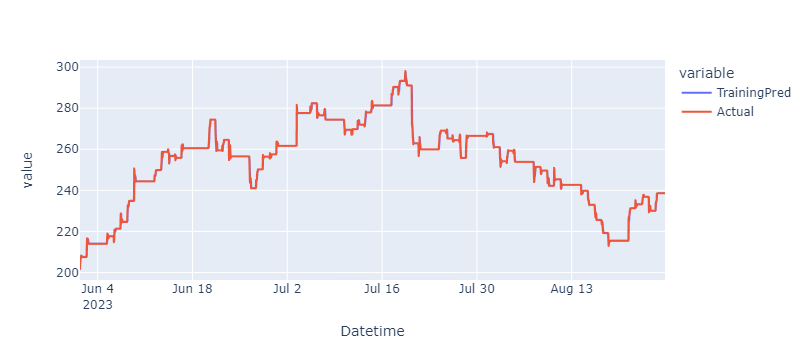

In [251]:
d=pd.DataFrame({"TrainingPred":y_pred,"Actual":y_train})
fig=px.line(d)
fig.show()

Communicating residuals

In [237]:
training_residuals=model.resid
training_residuals

Datetime
2023-06-01 13:30:00    1.181708
2023-06-01 14:30:00   -0.506230
2023-06-01 15:30:00   -0.557498
2023-06-01 16:30:00   -0.206794
2023-06-01 17:30:00   -0.160956
                         ...   
2023-08-26 14:30:00   -0.062310
2023-08-26 15:30:00   -0.062310
2023-08-26 16:30:00   -0.062310
2023-08-26 17:30:00   -0.062310
2023-08-26 18:30:00   -0.062310
Freq: H, Length: 2070, dtype: float64

<Axes: ylabel='Frequency'>

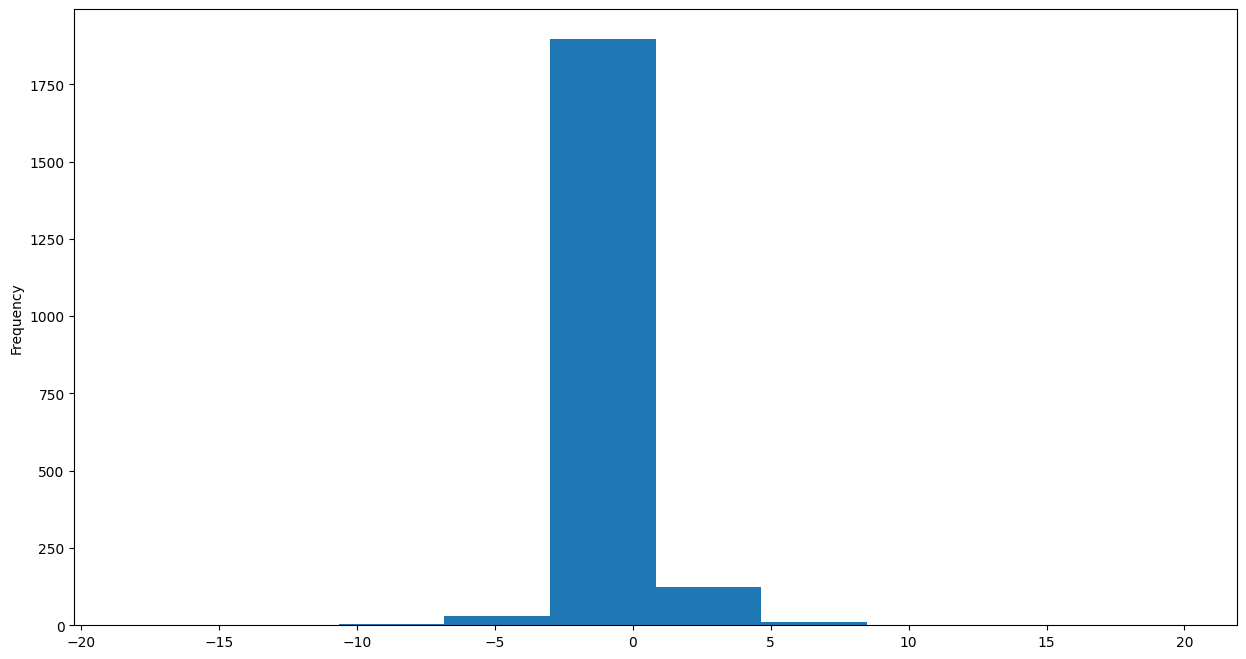

In [238]:
fig,ax=plt.subplots(figsize=(15,8))
training_residuals.plot(kind="hist",ax=ax)

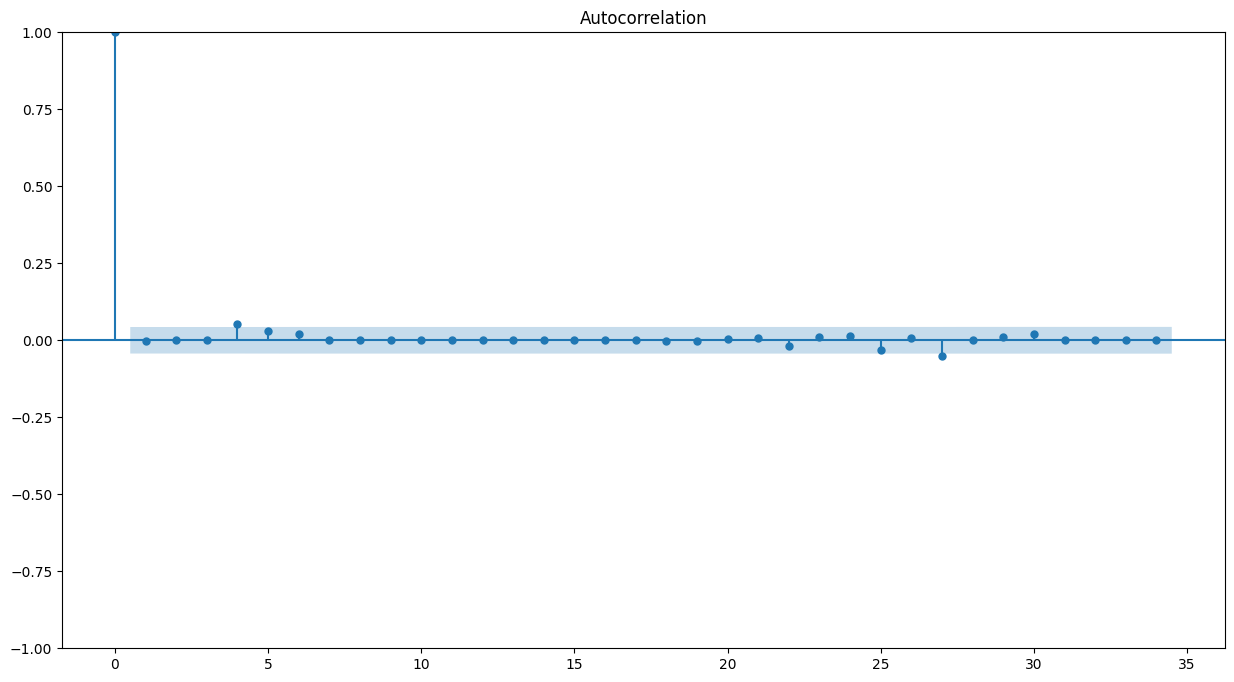

In [239]:
fig,ax=plt.subplots(figsize=(15,8))
plot_acf(training_residuals,ax=ax);

Evaluating the model with the testing data

In [240]:
y_pred_test=model.predict(y_test.index.min(),y_test.index.max())
mae_test=mean_absolute_error(y_test,y_pred_test)
print(f"Mean absolute error for the performance of test data is : {mae_test}")

Mean absolute error for the performance of test data is : 5.541344826270385


In [241]:
d1=pd.DataFrame({"TestingPred":y_pred_test,"Actual":y_test})

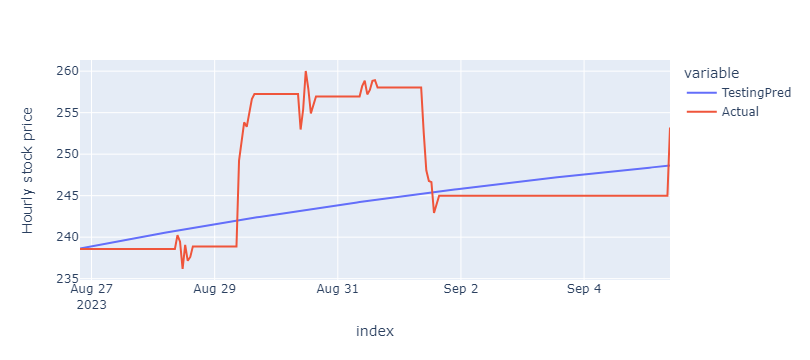

In [252]:
fig=px.line(d1,labels={"value":"Hourly stock price"})
fig.show()

<h3> Using Walk Forward validation </h3>

In [244]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [245]:
y_pred_wfv=pd.Series()
history=y_train.copy()
l=1
for i in range(0,len(y_test)):
    model=AutoReg(history,lags=4).fit()
    next=model.forecast()
    y_pred_wfv=y_pred_wfv.append(next)
    history=history.append(y_test[next.index])

In [246]:
wfv_mae=mean_absolute_error(y_test,y_pred_wfv)
print(f"The mean absolute error after using walk forward validation = {wfv_mae}")

The mean absolute error after using walk forward validation = 0.3881034586914224


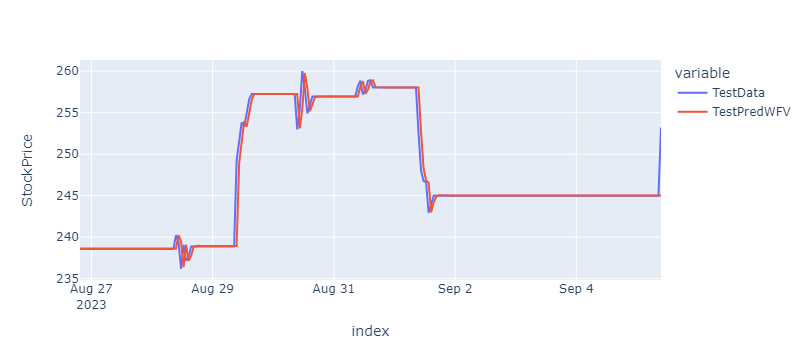

In [253]:
d2=pd.DataFrame({"TestData":y_test,"TestPredWFV":y_pred_wfv})
fig=px.line(d2,labels={"value":"StockPrice"})
fig.show()

<h3>Communicating results using the model parameters</h3>

In [248]:
print(model.params)

const       0.846290
Close.L1    0.978844
Close.L2   -0.005746
Close.L3    0.051559
Close.L4   -0.027937
dtype: float64


In [249]:
coefficients = {
    'const': 0.854519,
    'Close.L1': 0.978537,
    'Close.L2': -0.004670,
    'Close.L3': 0.050932,
    'Close.L4': -0.028107
}

equation = ' + '.join([f"{key} * {value:.4f}" for key, value in coefficients.items()])
equation = f"y = {equation}"
print(equation)


y = const * 0.8545 + Close.L1 * 0.9785 + Close.L2 * -0.0047 + Close.L3 * 0.0509 + Close.L4 * -0.0281
